<a href="https://colab.research.google.com/github/dalexa10/Scientific_Visualization/blob/main/11_Bioinformatics_Visualization/Force_directed_layout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
__author__ = 'Dario Rodriguez'

# Force-Directed Layout

The Force-Directed Graph Layout algorithm from Fruchterman and Reingold, developed in the 1990s (at the University of Illinois at Urbana Champaign) will be implemented. The original paper can be found at: https://onlinelibrary.wiley.com/doi/epdf/10.1002/spe.4380211102

The pseudocode for the Fruchterman-Reingold algorithm is also shown below:

<img src="https://raw.githubusercontent.com/dalexa10/Scientific_Visualization/main/11_Bioinformatics_Visualization/pseudo_code.png" width=480px>

We will use the NetworkX library, which is a Python package supporting data structures and functions for computations on graphs. You can find documentation at https://networkx.org/documentation/stable/reference/index.html.

As usual, we will begin by importing the necessary modules.

In [2]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from random import random
from numpy import arange

Now let's set the dimensions of our canvas.

In [3]:
import math
W = 1    # Width of the frame
L = 1    # Length of the frame
area = W*L

## Calculate attractive force between two vertices
Let's complete the function below to calculate the magnitude of the attractive force between two vertices.

The parameters of this function are:
- `d`: the distance between the two vertices
- `k`: the constant k = C*sqrt(area/# of vertices)

In [4]:
# Attractive force calculation
def f_a(d,k):
    f_att = d**2 / k
    return f_att

In [5]:
# Testing
np.testing.assert_allclose(f_a(4,3), 5.33, atol=0.01,rtol=0)
np.testing.assert_allclose(f_a(3,3.4), 2.65, atol=0.01,rtol=0)
np.testing.assert_allclose(f_a(4,3.4), 4.71, atol=0.01,rtol=0)

## Calculate repulsive force between two vertices
Let's complete the function below to calculate the magnitude of the repulsive force between two vertices.

The parameters of this function are:
- `d`: the distance between the two vertices
- `k`: the constant k = C*sqrt(area/# of vertices)

In [6]:
# Repulsive force calculation
def f_r(d,k):
    f_repul =  k**2 / abs(d)
    return f_repul

In [7]:
# Testing

np.testing.assert_allclose(f_r(4,3), 2.25, atol=0.01,rtol=0)
np.testing.assert_allclose(f_r(3,3.4), 3.85, atol=0.01,rtol=0)
np.testing.assert_allclose(f_r(3,4), 5.33, atol=0.01,rtol=0)


The skeleton code for the rest of the algorithm is shown below. To make things easier, we have provided the code to calculate the repulsive forces in the graph and to limit the maximum displacement.

We use the NetworkX API (https://networkx.org/documentation/stable//release/api_1.9.html) to generate and represent a graph `G`.

For a graph G, using the NetworkX API, you can

1. Iterate over nodes with: `for v in G.nodes()`.
2. Iterate over edges with v and u being keys to the two vertices that joined by the edge in G with: `for v,u in G.edges()`.
3. Access the x coordinate of v with: `G.nodes[v]['x']`; Using the key 'y' will access the y coordinate.
4. We should accumulate displacements from forces for a vertex v by accumulating the displacements in:
	`G.nodes[v]['dx']`
	`G.nodes[v]['dy']`
    
The parameters of `fruchterman_reingold()` are:
- `G`: a NetworkX graph
- `iteration`: the number of iterations

This function will return `pos`, a dictionary of (vertex, position) pairs.

In [8]:
def fruchterman_reingold(G,iteration):

    area = W*L
    k = math.sqrt(area/nx.number_of_nodes(G))

    t = W/2
    dt = t/(iteration+1)

    for i in range(iteration):
        #print(i, " of ", iteration)

        G = calculate_repulsive_forces(G, k)

        G = calculate_attractive_forces(G, k)

        # Limit the maximum displacement to the temperature t
        # and then prevent from being displaced outside frame
        for v in G.nodes():
            dx = G.nodes[v]['dx']
            dy = G.nodes[v]['dy']
            disp = math.sqrt(dx*dx+dy*dy)
            if disp != 0:
                d = min(disp,t)/disp
                x = G.nodes[v]['x'] + dx*d
                y = G.nodes[v]['y'] + dy*d
                x =  min(W,max(0,x)) - W/2
                y =  min(L,max(0,y)) - L/2
                G.nodes[v]['x'] = min(math.sqrt(W*W/4-y*y),max(-math.sqrt(W*W/4-y*y),x)) + W/2
                G.nodes[v]['y'] = min(math.sqrt(L*L/4-x*x),max(-math.sqrt(L*L/4-x*x),y)) + L/2

        # Cooling
        t -= dt

    pos = {}
    for v in G.nodes():
        pos[v] = [G.nodes[v]['x'],G.nodes[v]['y']]

    plt.close()
    plt.ylim([-0.1,1.1])
    plt.xlim([-0.1,1.1])
    plt.axis('off')

    return pos


Below is the first part of the Fruchterman-Reingold algorithm, which will calculate the repulsive forces for an entire graph `G`.

The parameters of `calculate_repulsive_forces` are:
- `G`: a NetworkX graph
- `k`: the constant k = C*sqrt(area/# of vertices)

This function will return the updated graph `G` with accumulated displacements stored in `G.nodes[v]['dx']` and `G.nodes[v]['dy']`.

In [9]:
def calculate_repulsive_forces(G, k):
    for v in G.nodes():
        G.nodes[v]['dx'] = 0
        G.nodes[v]['dy'] = 0
        for u in G.nodes():
            if v != u:
                dx = G.nodes[v]['x'] - G.nodes[u]['x']
                dy = G.nodes[v]['y'] - G.nodes[u]['y']
                delta = math.sqrt(dx*dx+dy*dy)
                if delta != 0:
                    d = f_r(delta,k)/delta
                    G.nodes[v]['dx'] += dx*d
                    G.nodes[v]['dy'] += dy*d
    return G

## Calculate attractive forces
Let's complete the function below to calculate the attractive forces for the entire graph `G`.

The parameters of `calculate_attractive_forces` are:
- `G`: a NetworkX graph
- `k`: the constant k = C*sqrt(area/# of vertices)

This function will return the updated graph `G` with accumulated displacements stored in `G.nodes[v]['dx']` and `G.nodes[v]['dy']`.

In [15]:
def calculate_attractive_forces(G, k):
    for v, u in G.edges():
        dx = G.nodes[v]['x'] - G.nodes[u]['x']
        dy = G.nodes[v]['y'] - G.nodes[u]['y']
        delta = math.sqrt(dx*dx+dy*dy)
        if delta != 0:
            d = - f_a(delta,k)/delta
            G.nodes[v]['dx'] += dx*d
            G.nodes[v]['dy'] += dy*d

            G.nodes[u]['dx'] -= dx*d
            G.nodes[u]['dy'] -= dy*d

    return G

In [19]:
### Testing
N = 5
G = nx.cycle_graph(N)

G.nodes[0]['x'] = 0.8168184889480099
G.nodes[0]['y'] = 0.5311428534216505
G.nodes[1]['x'] = 0.6654594641114429
G.nodes[1]['y'] = 0.7842081286602168
G.nodes[2]['x'] = 0.9229503471222402
G.nodes[2]['y'] = 0.21495774524514744
G.nodes[3]['x'] = 0.1353894225040374
G.nodes[3]['y'] = 0.9657448268419787
G.nodes[4]['x'] = 0.037138912320340944
G.nodes[4]['y'] = 0.578448424341083

for v in G.nodes():
    G.nodes[v]['dx'] = 0
    G.nodes[v]['dy'] = 0

k = math.sqrt(area/nx.number_of_nodes(G))

G_a = calculate_attractive_forces(G, k)

np.testing.assert_allclose(G_a.nodes[0]['dx'], -1.46, atol=0.01,rtol=0)
np.testing.assert_allclose(G_a.nodes[0]['dy'], 0.25, atol=0.01,rtol=0)
np.testing.assert_allclose(G_a.nodes[1]['dx'], 0.46, atol=0.01,rtol=0)
np.testing.assert_allclose(G_a.nodes[1]['dy'], -0.96, atol=0.01,rtol=0)
np.testing.assert_allclose(G_a.nodes[2]['dx'], -2.28, atol=0.01,rtol=0)
np.testing.assert_allclose(G_a.nodes[2]['dy'], 2.62, atol=0.01,rtol=0)





Here is the image of a randomly generated cycle with 5 vertices:


<img src="https://raw.githubusercontent.com/dalexa10/Scientific_Visualization/main/11_Bioinformatics_Visualization/before.png" width=360px>


Now, let's run the entire algorithm on the graph and draw the result.
Here is the image of the graph processed by the Fruchterman-Reingold algorithm.

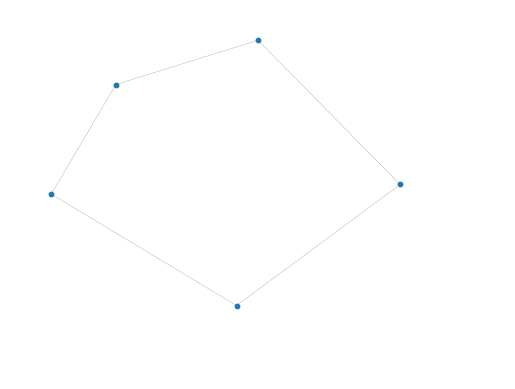

In [20]:
pos = fruchterman_reingold(G,200)
nx.draw_networkx(G,pos=pos,node_size=10,width=0.1,with_labels=False)

Finally, we will randomly generate a new graph with 30 vertices and run the Fruchterman-Reingold algorithm on that.

Please note that generating the result image may take a couple seconds.

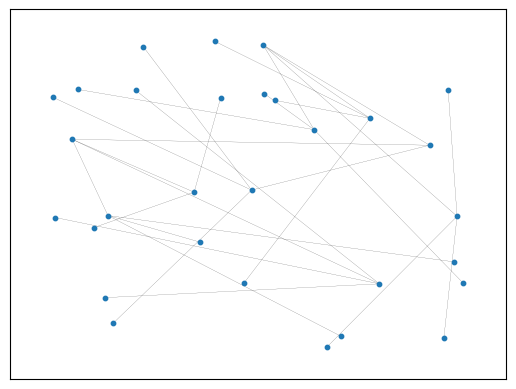

In [21]:
G = nx.full_rary_tree(3,30)
# initial position
for v in nx.nodes(G):
    G.nodes[v]['x'] = W*random()
    G.nodes[v]['y'] = L*random()

pos = {}
for v in G.nodes():
    pos[v] = [G.nodes[v]['x'],G.nodes[v]['y']]

nx.draw_networkx(G,pos=pos,node_size=10,width=0.1,with_labels=False)

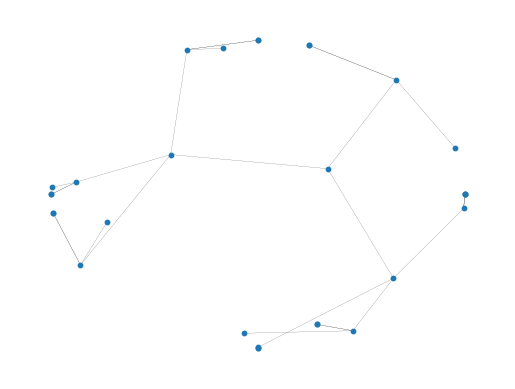

In [22]:
pos = fruchterman_reingold(G,1000)

plt.close()
plt.ylim([-0.1,1.1])
plt.xlim([-0.1,1.1])
plt.axis('off')
nx.draw_networkx(G,pos=pos,node_size=10,width=0.1,with_labels=False)